In [1]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd

import jax.numpy as jnp
from jax import lax, random
from jax.scipy.special import expit

import numpyro
from numpyro.diagnostics import hpdi, print_summary, summary
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.infer import Predictive, SVI, Trace_ELBO, init_to_value, log_likelihood, NUTS, MCMC, Predictive
from numpyro.infer.autoguide import AutoLaplaceApproximation, AutoNormal

A good answer: https://github.com/asuagar/statrethink-course-numpyro-2019/blob/main/statrethink_numpyro_w06.ipynb 

Qn1. The data in data(NWOGrants) are outcomes for scientific funding applications
for the Netherlands Organization for Scientific Research (NWO) from 2010–2012
(see van der Lee and Ellemers doi:10.1073/pnas.1510159112). These data have a
very similar structure to the UCBAdmit data discussed in Chapter 11. Draw a DAG
for this sample and then use one or more binomial GLMs to estimate the TOTAL
causal effect of gender on grant awards.

In [2]:
# read in the data 
# the data is from https://github.com/StatisticalRethinkingJulia/DynamicHMCModels.jl/blob/master/data/NWOGrants.csv
nwo_df=pd.read_csv('../Data/NWOGrants.csv', delimiter=";")
nwo_df.head(3)

,discipline,gender,applications,awards
0,Chemical sciences,m,83,22
1,Chemical sciences,f,39,10
2,Physical sciences,m,135,26


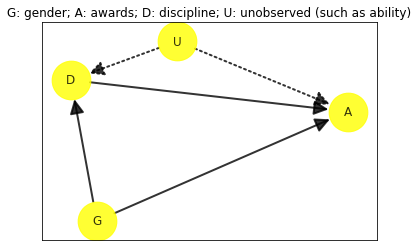

In [14]:
# draw DAG
import networkx as nx
graph = nx.DiGraph()
graph.add_edges_from([("G", "A"), ("D", "A"), ("G", "D"), 
                      ("U", "A"), ("U", "D")
                     ])
nx.draw_networkx(graph, arrows=True, alpha=0.8, node_color = 'yellow',
                width=2, node_size=1500, arrowsize = 30, style=['-']*3 + [':']*2)
plt.title ("G: gender; A: awards; D: discipline; U: unobserved (such as ability)")
plt.show()

In [4]:
# Total causal effect of gender on grant awards, with binomial GLM 

# gender to numbers. female:1; male:0
nwo_df['g'] = nwo_df.gender.apply(lambda x:1 if x =='f' else 0)

# model 
def m1(g, applications, awards=None):
    # priors
    a = numpyro.sample('a', dist.Normal(-1,1), sample_shape=(2,))
    # likelihood
    logits = a[g]
    numpyro.sample('awards_hat', dist.Binomial(applications, logits=logits), obs=awards)

rng_key = random.PRNGKey(101)
kernel = NUTS(m1)
mcmc = MCMC(kernel, num_warmup=500, num_samples=500, num_chains=4, chain_method='sequential')
mcmc.run(rng_key, 
        g=nwo_df.g.values, 
        applications=nwo_df.applications.values, 
        awards=nwo_df.awards.values)
mcmc.print_summary()

sample: 100%|██████████| 1000/1000 [00:00<00:00, 2819.81it/s, 3 steps of size 8.77e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      a[0]     -1.54      0.06     -1.54     -1.64     -1.44   1924.50      1.00
      a[1]     -1.74      0.08     -1.73     -1.86     -1.59   1960.50      1.00

Number of divergences: 0


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>]], dtype=object)

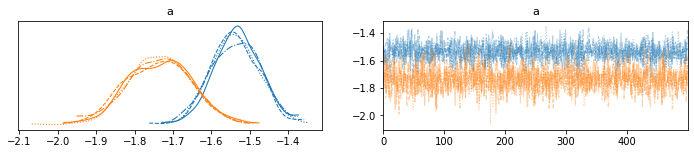

In [5]:
samples = az.from_numpyro(mcmc)
az.plot_trace(samples)

On average, male (blue trace) has a higher chance to be the grant than female (orange trace)  

In [6]:
# difference btw male and female 
posterior = mcmc.get_samples()
prob_m = round(jnp.mean(expit(posterior['a'][:,0])),2)
prob_f = round(jnp.mean(expit(posterior['a'][:,1])),2)
print(f'prob_m = {prob_m:.2f}, prob_f = {prob_f:.2f}, difference = {prob_m-prob_f:.2f}')

prob_m = 0.18, prob_f = 0.15, difference = 0.03


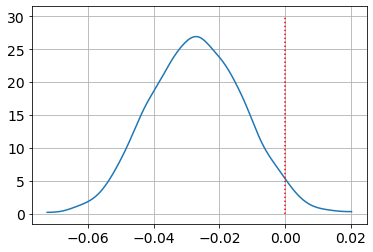

In [7]:
az.plot_dist(expit(posterior['a'][:,1])-expit(posterior['a'][:,0]))
plt.vlines(x=0, ymin=0, ymax=30, color='r', ls=':')
plt.grid()

Qn2. Now estimate the DIRECT causal effect of gender on grant awards. Compute
the average direct causal effect of gender, weighting each discipline in proportion to
the number of applications in the sample. Refer to the marginal effect example in
Lecture 9 for help

In [8]:
import numpy as np

# discipline into numbers 
nwo_df['d'] = pd.factorize(nwo_df['discipline'])[0]

# model 
def m2(g, d, applications, awards=None):
    # priors
    d_ct = len(np.unique(d)) # interestingly, using jnp here gives error
    gend = numpyro.sample('gend', dist.Normal(-1,1), sample_shape=(2,))
    disp = numpyro.sample('disp', dist.Normal(0,1), sample_shape=(d_ct,))
    # likelihood
    logits = gend[g] + disp[d]
    numpyro.sample('awards_hat', dist.Binomial(applications, logits=logits), obs=awards)

rng_key = random.PRNGKey(0)
kernel = NUTS(m2)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=4, chain_method='sequential')
mcmc.run(rng_key, 
        g=nwo_df.g.values, 
        d=nwo_df.d.values,
        applications=nwo_df.applications.values, 
        awards=nwo_df.awards.values)
mcmc.print_summary()

sample: 100%|██████████| 2000/2000 [00:00<00:00, 2794.44it/s, 7 steps of size 1.94e-01. acc. prob=0.91] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   disp[0]      0.32      0.36      0.32     -0.24      0.91    682.42      1.00
   disp[1]     -0.02      0.35     -0.01     -0.57      0.58    698.33      1.00
   disp[2]      0.29      0.39      0.29     -0.34      0.93    777.80      1.00
   disp[3]     -0.23      0.33     -0.23     -0.80      0.27    596.47      1.00
   disp[4]     -0.21      0.34     -0.21     -0.78      0.33    634.89      1.00
   disp[5]     -0.28      0.36     -0.28     -0.87      0.33    672.04      1.00
   disp[6]     -0.00      0.33     -0.00     -0.51      0.59    618.16      1.00
   disp[7]     -0.45      0.32     -0.45     -0.98      0.07    567.42      1.00
   disp[8]     -0.34      0.33     -0.34     -0.88      0.19    579.67      1.00
   gend[0]     -1.34      0.31     -1.33     -1.85     -0.83    536.95      1.00
   gend[1]     -1.48      0.31     -1.47     -1.99     -0.97    543.70      1.00

Number of divergences: 0


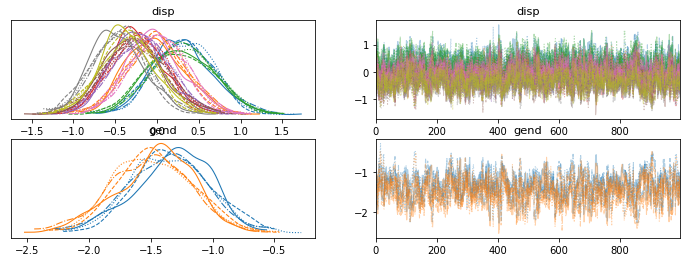

In [9]:
samples = az.from_numpyro(mcmc)
az.plot_trace(samples);

In [10]:
# difference btw male and female 
posterior = mcmc.get_samples()
prob_m = round(jnp.mean(expit(posterior['gend'][:,0])),2)
prob_f = round(jnp.mean(expit(posterior['gend'][:,1])),2)
print(f'prob_m = {prob_m:.2f}, prob_f = {prob_f:.2f}, difference = {prob_m-prob_f:.2f}')

prob_m = 0.21, prob_f = 0.19, difference = 0.02


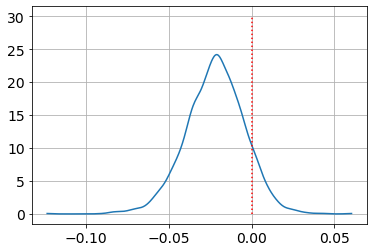

In [11]:
# ???? 
az.plot_dist(expit(posterior['gend'][:,1])-expit(posterior['gend'][:,0]))
plt.vlines(x=0, ymin=0, ymax=30, color='r', ls=':')
plt.grid()

The direct effect of gender on awards shows that male is 2% more likely than female to get the grant, on average. However, this relationship doesn't hold true across all disciplines. Female can have a better advantage in certain disciplines. 

3. Considering the total effect (problem 1) and direct effect (problem 2) of gender,
what causes contribute to the average difference between women and men in award
rate in this sample? It is not necessary to say whether or not there is evidence of
discrimination. Simply explain how the direct effects you have estimated make sense
(or not) of the total effect.

In [12]:
nwo_df['application_rate_by_gender'] = nwo_df.applications/nwo_df.groupby('gender').applications.transform(sum)
#nwo_df['award_rate_by_gender'] = nwo_df.awards/nwo_df.groupby('gender').applications.transform(sum)
#nwo_df['award_rate_by_discipline'] = nwo_df.groupby('discipline').awards.transform(sum)/nwo_df.groupby('discipline').applications.transform(sum)
nwo_df['award_rate'] = nwo_df.awards/nwo_df.applications


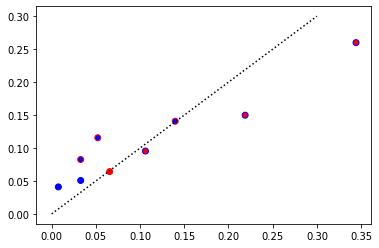

In [13]:
pDf = nwo_df[nwo_df.gender=='f']['application_rate_by_gender']
pDm = nwo_df[nwo_df.gender=='m']['application_rate_by_gender']
pAf = nwo_df[nwo_df.gender=='f']['award_rate'] #????
pAm = nwo_df[nwo_df.gender=='m']['award_rate'] #????

plt.scatter(pDf, pDm, color = ['r' if f>=m else 'b' for f,m in zip(pDf,pDm)], 
                 edgecolors = ['r' if f>=m else 'b' for f,m in zip(pAf,pAm)], )
plt.plot(np.linspace(0,0.3,10),np.linspace(0,0.3,10), ls=":", c= 'k')